# Identitas Diri
Nama : Indiarto Aji Begawan \
Email : indiartoaji13@gmail.com \
Learning Path : Belajar Pengembangan Machine Learning \
Materi : Proyek Akhir - Image Classification Model Deployment \


# Library

In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

# Collect data from local

Dataset Rice Image diambil dari website Kaggle dengan nama yang sama. Link datasetnya adalah : https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset.
Proyek ini menggubakan beberapa dataset dari Kaggle yaitu Sea Animal Image, Yoga Posture, Animals-10, dan Rice Image. Tiga dataset pertama menghasilkan nilai akurasi, waktu training serta improvement tiap epoch pada train dan validation data yang kurang baik.

In [3]:
# base_path = 'Belajar Pengembangan Machine Learning/Asset/SeaAnimalsImageDataset/'
# base_path = 'Belajar Pengembangan Machine Learning/Asset/YogaPostureDataset/'
# base_path = 'Belajar Pengembangan Machine Learning/Asset/Animals-10Dataset/'
base_path = 'Belajar Pengembangan Machine Learning/Asset/RiceImageDataset/'

files_names = os.listdir(base_path)

In [4]:
sum = 0
for i, names in enumerate(files_names):
  print(f"{names} : {len(os.listdir((base_path+names)))}")
  sum += len(os.listdir((base_path+names)))

print(f"\nSum of all images : {sum}")
num_classes = i+1
print(f"Number of classes : {num_classes}")

Arborio : 3000
Basmati : 3000
Ipsala : 3000
Jasmine : 3000
Karacadag : 3000

Sum of all images : 15000
Number of classes : 5


# Pre-Processing

In [5]:
train_dir = os.path.join(base_path)
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode = 'nearest',
    brightness_range=[0.5,2.0],
    horizontal_flip=True,
    validation_split=0.2) # set validation split

In [6]:
size = (150,150)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=size,
    batch_size=8,
    class_mode='categorical',
    subset='training') # set as training data
validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=size,
    batch_size=16,
    class_mode='categorical',
    subset='validation')

Found 12000 images belonging to 5 classes.
Found 3000 images belonging to 5 classes.


# Training Model

In [9]:
reg = regularizers.l2(l=0.01)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='valid', input_shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='valid',kernel_regularizer=reg),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='valid',kernel_regularizer=reg),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='valid',kernel_regularizer=reg),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),  
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='valid',kernel_regularizer=reg), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='valid',kernel_regularizer=reg), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='valid',kernel_regularizer=reg), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='valid',kernel_regularizer=reg), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),  
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  
])
# Callbacks
saved_path = "./Belajar Pengembangan Machine Learning/models/ProyekAkhir.h5"
checkpoint = ModelCheckpoint(saved_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
reducelr   = ReduceLROnPlateau(monitor='val_accuracy', factor=0, patience=100, min_delta=0.01,verbose=1)
cb_list    = [checkpoint, reducelr]

model.summary()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 146, 146, 32)      18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 71, 71, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 69, 69, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 34, 34, 32)       0         
 2D)                                                  

In [10]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=25,
                    verbose=1,
                    callbacks=cb_list)

Epoch 1/25
1499/1500 [============================>.] - ETA: 0s - loss: 1.8617 - accuracy: 0.7880
Epoch 1: val_accuracy improved from -inf to 0.85167, saving model to ./Belajar Pengembangan Machine Learning/models\ProyekAkhir.h5
1500/1500 [==============================] - 119s 79ms/step - loss: 1.8610 - accuracy: 0.7882 - val_loss: 1.0372 - val_accuracy: 0.8517 - lr: 1.0000e-04
Epoch 2/25
1500/1500 [==============================] - ETA: 0s - loss: 0.8802 - accuracy: 0.8390
Epoch 2: val_accuracy improved from 0.85167 to 0.85733, saving model to ./Belajar Pengembangan Machine Learning/models\ProyekAkhir.h5
1500/1500 [==============================] - 55s 37ms/step - loss: 0.8802 - accuracy: 0.8390 - val_loss: 0.7120 - val_accuracy: 0.8573 - lr: 1.0000e-04
Epoch 3/25
1499/1500 [============================>.] - ETA: 0s - loss: 0.6596 - accuracy: 0.8477
Epoch 3: val_accuracy did not improve from 0.85733
1500/1500 [==============================] - 55s 37ms/step - loss: 0.6594 - accuracy:

Hasil training model menghasilkan nilai training accuracy sebesar 95,81% dan validation accuracy sebesar 96,97%.

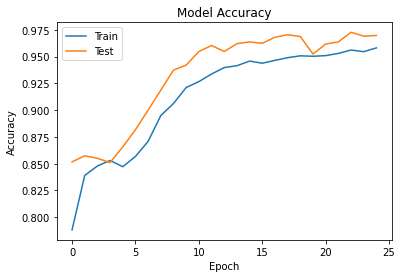

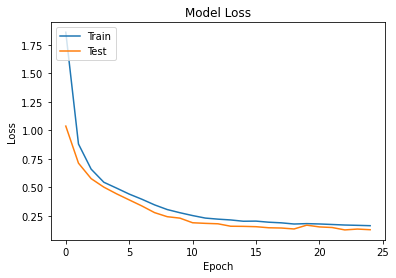

In [12]:
# Grafik Accuracy dan Validation Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Grafik Accuracy dan Validation Accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Save model to TF-Lite

In [13]:
save_path = './Belajar Pengembangan Machine Learning/models/ProyekAkhir'
tf.saved_model.save(model, save_path)

INFO:tensorflow:Assets written to: ./Belajar Pengembangan Machine Learning/models/ProyekAkhir\assets


INFO:tensorflow:Assets written to: ./Belajar Pengembangan Machine Learning/models/ProyekAkhir\assets


In [19]:
model_path = './Belajar Pengembangan Machine Learning/models/ProyekAkhir'
converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
tflite_model = converter.convert()

with tf.io.gfile.GFile('./Belajar Pengembangan Machine Learning/models/ProyekAkhir.tflite', 'wb') as f:
    f.write(tflite_model)